## Evocação do ritmo alpha

### 1. Importação das bibliotecas

In [255]:
%matplotlib inline

import matplotlib.pyplot as plt
import mne
import numpy as np
from copy import deepcopy
from mne.time_frequency import psd_welch as pw

### 2. Definição dos eletrodos e frequências

In [256]:
ch_names = ['po3', 'po4', 'p8', 'o1', 'o2', 'p7']
alpha = []
beta = []
theta = []
gamma = []
md_alpha = []
md_beta = []
md_theta = []
md_gamma = []
md_ritmos = []
global count
count = 0

### 3. Leitura do arquivo

A função a seguir (*load\_data*) faz o carregamento do arquivo com o conjunto de frequências _alpha_, _beta_, _gamma_, _delta_ e _theta_, obtidas a partir das leituras dos eletrodos definidos anteriormente.

In [257]:
def load_data(file):
    with open(file, 'r') as f:
        data = f.readlines()
    
    compactData = []
    for i in range(len(data)):
        if i >= 6:
            compactData.append(data[i])

    return compactData

### 4. Extração das informações relativas às frequências

A seguir são apresentadas duas funções: _convert_ e *separate\_data*. A primeira retorna um array com as informações relativas apenas aos dados de frequência de uma linha de arquivo passada como parâmetro, pois as linhas do arquivo eram compostas por ID's, tempo e leitura de eletrodos que não eram importantes nesse momento. Já a segunda função faz um mapeamento dos segundos que não possuíam leitura completa, isto é, o arquivo é composto por vários blocos de 256 itens, sendo que cada bloco desse corresponde à leitura de 1 segundo. Porém, alguns desses blocos tinham informações faltando, nao tinham os 256 itens. Dessa forma, a função *separate\_data* percorre o arquivo identificando quais são esses blocos defeituosos e, ao final, retorna um array com as informações relativas apenas às frequências (usa a função _convert_ para isso) dos segundos que possuem todas as informações.

In [258]:
def convert(data):
    temp = []
    line = data.split(',')

    for e in range(len(line)):
        if e > 0 and e <= 6:
            temp.append(float(line[e]))
    
    return temp

def separate_data(data):
    index = []
    temp = []
    count = 0

    for e in range(len(data)):
        idx = data[e].split(',')[0]
        if int(idx) == 255 and count == 255:
            index.extend(temp)
            temp = []
            count = 0
        elif int(idx) == 255 and count < 255:
            temp = []
            count = 0
        else:
            temp.append(convert(data[e]))
            count += 1
    
    return index

In [259]:
data = load_data('dataset_alpha/RAW_00.txt')
newData = separate_data(data)
size = int(len(newData)/256)

### 5. Plotando gráfico com os dados originais

A função *plot\_graph* constrói o gráfico com a leitura das frequências obtida dos dados. Até o momento, os dados estão em seu estado original, sem a aplicação de nenhum tipo de filtro.

In [260]:
def plot_graph(data):
    newData = np.asarray(data)
    newData = newData.T
    ch_types = ['eeg'] * 6

    info = mne.create_info(ch_names=ch_names, sfreq=256, ch_types=ch_types)
    raw = mne.io.RawArray(newData, info, verbose=False)
    
    montage = mne.channels.read_montage('standard_1020')
    raw.set_montage(montage)
    
    print("*******Dados originais*******\n")
    raw.plot_psd()
    return raw

*******Dados originais*******



<ipython-input-260-89cf24c02c2f>:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  raw.plot_psd()


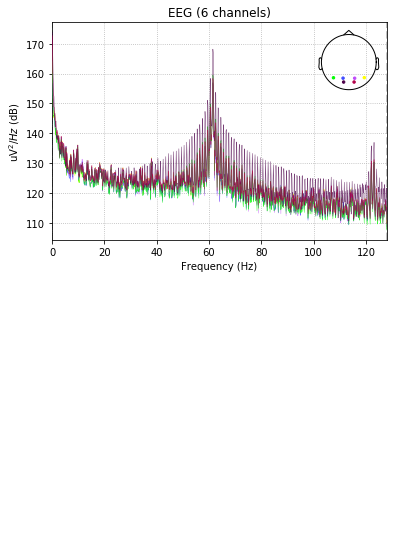

In [261]:
raw = plot_graph(newData)

### 6. Aplicando filtro notch

Com o intuito de reduzir o ruído nos dados, a função a seguir faz a aplicação do filtro notch.

In [262]:
def apply_notch(raw):
    newRaw = deepcopy(raw)
    newRaw.notch_filter(np.arange(60, 121, 60), fir_design='firwin')
    newRaw.filter(8., 50., fir_design='firwin')
    
    print("*******Dados com filtro notch*******\n")
    newRaw.plot_psd(area_mode='range', verbose=False)
    print()
    return newRaw

*******Dados com filtro notch*******



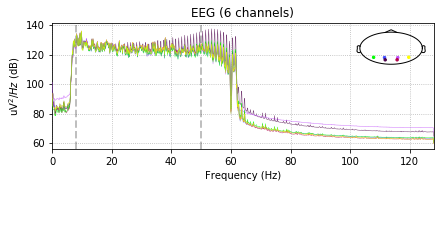

In [263]:
raw = apply_notch(raw)

### 7. Aplicando filtro bandpass

Para reduzir ainda mais os ruídos, a função a seguir aplica 10 vezes o filtro bandpass nos dados.

In [264]:
def apply_bandpass(raw):
    newRaw = deepcopy(raw)
    
    for i in range(0, 9):
        newRaw.filter(l_freq=8., h_freq=50.)
        
    return newRaw

### 8. Média quadrática

A função a seguir realiza a média quadrática de um array passado como parâmetro.

In [265]:
def avg(data):
    soma = 0
    for i in range(0, len(data)):
        soma = data[i] ** 2
    res = soma/len(data)
    res = res ** 1/2
    return res

### 9. Janelamento com psd_welch

Foi feita uma análise dos dados por meio da ferramenta openBCI e, com isso, verificou-se quais foram os intervalos de tempo em que o ritmo _alpha_ estava mais alto. A tabela a seguir apresenta esses intervalos. Vale ressaltar que o tempo total era de 830 segundos.

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-baqh{text-align:center;vertical-align:top}
.tg .tg-c3ow{border-color:inherit;text-align:center;vertical-align:top}
.tg .tg-uys7{border-color:inherit;text-align:center}
.tg .tg-0lax{text-align:left;vertical-align:top}
</style>
<table class="tg" style="undefined;table-layout: fixed; width: 254px">
<colgroup>
<col style="width: 124px">
<col style="width: 130px">
</colgroup>
  <tr>
    <th class="tg-uys7"><span style="font-weight:bold">Início (s)</span></th>
    <th class="tg-uys7"><span style="font-weight:bold">Fim (s)</span></th>
  </tr>
  <tr>
    <td class="tg-uys7">11</td>
    <td class="tg-uys7">13</td>
  </tr>
  <tr>
    <td class="tg-uys7">77</td>
    <td class="tg-uys7">85</td>
  </tr>
  <tr>
    <td class="tg-c3ow">121</td>
    <td class="tg-c3ow">122</td>
  </tr>
  <tr>
    <td class="tg-c3ow">124</td>
    <td class="tg-c3ow">127</td>
  </tr>
  <tr>
    <td class="tg-baqh">198</td>
    <td class="tg-baqh">199</td>
  </tr>
  <tr>
    <td class="tg-baqh">244</td>
    <td class="tg-baqh">250</td>
  </tr>
  <tr>
    <td class="tg-baqh">252</td>
    <td class="tg-baqh">258</td>
  </tr>
  <tr>
    <td class="tg-baqh">300</td>
    <td class="tg-baqh">304</td>
  </tr>
  <tr>
    <td class="tg-baqh">314</td>
    <td class="tg-baqh">320</td>
  </tr>
  <tr>
    <td class="tg-baqh">410</td>
    <td class="tg-baqh">411</td>
  </tr>
  <tr>
    <td class="tg-0lax">607</td>
    <td class="tg-0lax">611</td>
  </tr>
</table>

A função a seguir constrói o gráfico para os intervalos passados como parâmetro e salva as intensidades dos eletrodos para cada um dos tipos de frequência.

In [266]:
def avg_freq():
    del md_alpha[0:-1]
    del md_beta[0:-1]
    del md_theta[0:-1]
    del md_gamma[0:-1]
    
    for i in range(0, 6):
        md_theta.append(avg(theta[i]))
        md_alpha.append(avg(alpha[i]))
        md_beta.append(avg(beta[i]))
        md_gamma.append(avg(gamma[i]))
        
def large_md(data):
    maior = -1
    pos = 0
    pos_aux = pos
    for i in range(0, len(data)):
        for element in data[i]:
            if element > maior:
                maior = element
                pos = pos_aux
            pos_aux += 1
        pos_aux = 0
    return pos-1

def plot_time_frequency(raw, i, f):
    del alpha[0:-1]
    del beta[0:-1]
    del theta[0:-1]
    del gamma[0:-1]
    
    newRaw = apply_bandpass(raw)
    
    psds, freqs = pw(newRaw, 5., 50., i, f)
    print("*******Dados após psd_welch*******\n")      
    for j in range(0, 6):
        theta.append(psds[j][0:3])
        alpha.append(psds[j][3:8])
        beta.append(psds[j][8:25])
        gamma.append(psds[j][20:46])
#         plt.show()
    avg_freq()

In [267]:
def extract_large():
    del md_ritmos[0:-1]
    md_ritmos.append(md_alpha)
    md_ritmos.append(md_beta)
    md_ritmos.append(md_gamma)
    md_ritmos.append(md_theta)
    
    idx = large_md(md_ritmos)
    maior = max(md_alpha[idx], md_beta[idx], md_theta[idx], md_gamma[idx])
    global count
    if md_alpha[idx] == maior:
        count += 1
        print("Comparação do maior valor em eletrodo considerando todos os ritmos:")
        print("Eletrodo: ", end = '')
        print(ch_names[idx])
        print("Alpha (8-12)Hz: ", end = '')
        print(md_alpha[idx])
        print("Beta (12-30)Hz: ", end = '')
        print(md_beta[idx])
        print("Gamma (25-50)Hz: ", end = '')
        print(md_gamma[idx])
        print("Theta (4-7)Hz: ", end = '')
        print(md_theta[idx])
        print("\n")
    
        segundo_maior = max(md_beta[idx], md_theta[idx], md_gamma[idx])
        diferenca = md_alpha[eletrodo_tds_ritmos] - segundo_maior
        escala = (100*diferenca)/md_alpha[eletrodo_tds_ritmos]
        print("Média de alpha: ", md_alpha[eletrodo_tds_ritmos])
        print("Segunda maior média: ", segundo_maior)
        print("Valor na escala: ", escala)
    print('sdhjfb: ', count)

In [268]:
for i in range(1, 4):
    plot_time_frequency(raw, 0, i)
    extract_large()

for i in range(0, size):#size
    plot_time_frequency(raw, i, i+4)
    extract_large()

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

Comparação do maior valor em eletrodo considerando todos os ritmos:
Eletrodo: p7
Alpha (8-12)Hz: 0.23319924956611637
Beta (12-30)Hz: 0.0022599866022396746
Gamma (25-50)Hz: 0.00903255484543586
Theta (4-7)Hz: 0.03177040918669643


Média de alpha:  0.008247759614198533
Segunda maior média:  0.03177040918669643
Valor na escala:  -285.20047470835124
sdhjfb:  1
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

Comparação do maior valor em eletrodo considerando todos os ritmos:
Eletrodo: o2
Alpha (8-12)Hz: 0.24266732995661594
Beta (12-30)Hz: 0.07096433449685922
Gamma (25-50)Hz: 0.048236366089120374
Theta (4-7)Hz: 0.17364970230729218


Média de alpha:  0.24266732995661594
Segunda maior média:  0.17364970230729218
Valor na escala:  28.441252335723448
sdhjfb:  2
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

Comparação do maior valor em eletrodo considerando todos os ritmos:
Eletrodo:

*******Dados após psd_welch*******

sdhjfb:  19
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

Comparação do maior valor em eletrodo considerando todos os ritmos:
Eletrodo: o1
Alpha (8-12)Hz: 0.16034382645579692
Beta (12-30)Hz: 0.06955165153237286
Gamma (25-50)Hz: 0.03509598138539682
Theta (4-7)Hz: 0.01744045965945452


Média de alpha:  6.7998052032181295
Segunda maior média:  0.06955165153237286
Valor na escala:  98.97715229401784
sdhjfb:  20
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

Comparação do maior valor em eletrodo considerando todos os ritmos:
Eletrodo: o2
Alpha (8-12)Hz: 8.924891148171081
Beta (12-30)Hz: 0.22905508063525978
Gamma (25-50)Hz: 0.22126190538330123
Theta (4-7)Hz: 0.07513294420570656


Média de alpha:  8.924891148171081
Segunda maior média:  0.22905508063525978
Valor na escala:  97.43352521803924
sdhjfb:  21
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

Comparação do maior valor em eletrodo c

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

Comparação do maior valor em eletrodo considerando todos os ritmos:
Eletrodo: po4
Alpha (8-12)Hz: 0.15021530092425717
Beta (12-30)Hz: 0.00399670772104452
Gamma (25-50)Hz: 0.0926802805630235
Theta (4-7)Hz: 0.055130885518661236


Média de alpha:  0.14448455068584157
Segunda maior média:  0.0926802805630235
Valor na escala:  35.85453937940958
sdhjfb:  39
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

Comparação do maior valor em eletrodo considerando todos os ritmos:
Eletrodo: p7
Alpha (8-12)Hz: 0.3114472544890491
Beta (12-30)Hz: 0.04861790095111744
Gamma (25-50)Hz: 0.03881545250343488
Theta (4-7)Hz: 0.12270685225422917


Média de alpha:  0.017764160204280295
Segunda maior média:  0.12270685225422917
Valor na escala:  -590.7551544410346
sdhjfb:  40
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

sdhjfb:  40
Effective window size : 1.000 (s)
*******Dados após psd_welch*******


Effective window size : 1.000 (s)
*******Dados após psd_welch*******

Comparação do maior valor em eletrodo considerando todos os ritmos:
Eletrodo: o2
Alpha (8-12)Hz: 1.0678153983999779
Beta (12-30)Hz: 0.04425132329247362
Gamma (25-50)Hz: 0.010272457600657934
Theta (4-7)Hz: 0.006378265749297102


Média de alpha:  1.0678153983999779
Segunda maior média:  0.04425132329247362
Valor na escala:  95.85590137033235
sdhjfb:  58
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

Comparação do maior valor em eletrodo considerando todos os ritmos:
Eletrodo: po4
Alpha (8-12)Hz: 1.7527366215559141
Beta (12-30)Hz: 0.004877512341209721
Gamma (25-50)Hz: 0.005322094299269466
Theta (4-7)Hz: 0.0014390582552222147


Média de alpha:  1.0128341326940171
Segunda maior média:  0.005322094299269466
Valor na escala:  99.47453446448202
sdhjfb:  59
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

Comparação do maior valor em eletrodo considerando todos os ritmos:
Eletrodo: 

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

Comparação do maior valor em eletrodo considerando todos os ritmos:
Eletrodo: po4
Alpha (8-12)Hz: 0.6806920498175771
Beta (12-30)Hz: 0.03673137042108818
Gamma (25-50)Hz: 0.11962583268079324
Theta (4-7)Hz: 0.0041040477796037925


Média de alpha:  0.44063779731759933
Segunda maior média:  0.11962583268079324
Valor na escala:  72.85166333686752
sdhjfb:  77
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

Comparação do maior valor em eletrodo considerando todos os ritmos:
Eletrodo: po3
Alpha (8-12)Hz: 0.3551182092602643
Beta (12-30)Hz: 0.022444763878352567
Gamma (25-50)Hz: 0.11250120468630127
Theta (4-7)Hz: 0.003627548389411834


Média de alpha:  0.2575402980430073
Segunda maior média:  0.11250120468630127
Valor na escala:  56.31704803435679
sdhjfb:  78
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

Comparação do maior valor em eletrodo considerando todos os ritmos:
Eletrodo: p

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

Comparação do maior valor em eletrodo considerando todos os ritmos:
Eletrodo: p8
Alpha (8-12)Hz: 1.166760101907013
Beta (12-30)Hz: 0.019109773395939698
Gamma (25-50)Hz: 0.026372342473716653
Theta (4-7)Hz: 0.004419997051300234


Média de alpha:  0.6144868011048966
Segunda maior média:  0.026372342473716653
Valor na escala:  95.70823288209004
sdhjfb:  96
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

Comparação do maior valor em eletrodo considerando todos os ritmos:
Eletrodo: p8
Alpha (8-12)Hz: 2.510560278244958
Beta (12-30)Hz: 0.020562333706843055
Gamma (25-50)Hz: 0.024256028906421607
Theta (4-7)Hz: 0.00971811947528974


Média de alpha:  0.49561068118201124
Segunda maior média:  0.024256028906421607
Valor na escala:  95.10583007441004
sdhjfb:  97
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

Comparação do maior valor em eletrodo considerando todos os ritmos:
Eletrodo: po

*******Dados após psd_welch*******

Comparação do maior valor em eletrodo considerando todos os ritmos:
Eletrodo: p7
Alpha (8-12)Hz: 0.8932399568589604
Beta (12-30)Hz: 0.02798211028275018
Gamma (25-50)Hz: 0.03718033993284827
Theta (4-7)Hz: 0.004591046006383395


Média de alpha:  0.9212189066488294
Segunda maior média:  0.03718033993284827
Valor na escala:  95.96400598549357
sdhjfb:  115
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

Comparação do maior valor em eletrodo considerando todos os ritmos:
Eletrodo: o1
Alpha (8-12)Hz: 0.6950855792074301
Beta (12-30)Hz: 0.009201232813779365
Gamma (25-50)Hz: 0.013790671794054783
Theta (4-7)Hz: 0.004032196942948928


Média de alpha:  2.492527985084661
Segunda maior média:  0.013790671794054783
Valor na escala:  99.44671948011904
sdhjfb:  116
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

Comparação do maior valor em eletrodo considerando todos os ritmos:
Eletrodo: p7
Alpha (8-12)Hz: 1.662667382712948

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

Comparação do maior valor em eletrodo considerando todos os ritmos:
Eletrodo: po3
Alpha (8-12)Hz: 0.6462617119415509
Beta (12-30)Hz: 0.015013445067874116
Gamma (25-50)Hz: 0.008645743367964098
Theta (4-7)Hz: 0.04529804897464094


Média de alpha:  0.4862087128834
Segunda maior média:  0.04529804897464094
Valor na escala:  90.68341480225507
sdhjfb:  133
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

Comparação do maior valor em eletrodo considerando todos os ritmos:
Eletrodo: o1
Alpha (8-12)Hz: 0.22044096796294785
Beta (12-30)Hz: 0.0070989369047489955
Gamma (25-50)Hz: 0.006661863792414576
Theta (4-7)Hz: 0.06613847924891346


Média de alpha:  0.7943931167926247
Segunda maior média:  0.06613847924891346
Valor na escala:  91.67433883164186
sdhjfb:  134
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

Comparação do maior valor em eletrodo considerando todos os ritmos:
Eletrodo: o1

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

Comparação do maior valor em eletrodo considerando todos os ritmos:
Eletrodo: p7
Alpha (8-12)Hz: 0.6534182379896609
Beta (12-30)Hz: 0.15840613464345418
Gamma (25-50)Hz: 0.006326729235430874
Theta (4-7)Hz: 0.009111781939847121


Média de alpha:  0.5145037847785655
Segunda maior média:  0.15840613464345418
Valor na escala:  69.2118621223302
sdhjfb:  152
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

Comparação do maior valor em eletrodo considerando todos os ritmos:
Eletrodo: p7
Alpha (8-12)Hz: 0.726061523660799
Beta (12-30)Hz: 0.040358401138609466
Gamma (25-50)Hz: 0.0052109797296881815
Theta (4-7)Hz: 0.008828738059746793


Média de alpha:  0.8762667391535632
Segunda maior média:  0.040358401138609466
Valor na escala:  95.39427900942651
sdhjfb:  153
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

Comparação do maior valor em eletrodo considerando todos os ritmos:
Eletrodo: p

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

Comparação do maior valor em eletrodo considerando todos os ritmos:
Eletrodo: po4
Alpha (8-12)Hz: 0.16326768393448116
Beta (12-30)Hz: 0.010536966378641446
Gamma (25-50)Hz: 0.0010500607776941044
Theta (4-7)Hz: 0.0025380574426302036


Média de alpha:  0.22419220787133542
Segunda maior média:  0.010536966378641446
Valor na escala:  95.30003005961356
sdhjfb:  171
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

Comparação do maior valor em eletrodo considerando todos os ritmos:
Eletrodo: po4
Alpha (8-12)Hz: 0.1731488801372537
Beta (12-30)Hz: 0.0415581590792386
Gamma (25-50)Hz: 0.00197230578795931
Theta (4-7)Hz: 0.0017247527286528583


Média de alpha:  0.3602253725986863
Segunda maior média:  0.0415581590792386
Valor na escala:  88.46328930707027
sdhjfb:  172
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

Comparação do maior valor em eletrodo considerando todos os ritmos:
Eletro

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

Comparação do maior valor em eletrodo considerando todos os ritmos:
Eletrodo: p8
Alpha (8-12)Hz: 0.3389142340543055
Beta (12-30)Hz: 0.013804279061108518
Gamma (25-50)Hz: 0.005578457534496887
Theta (4-7)Hz: 0.013109509994362027


Média de alpha:  0.10921823544128431
Segunda maior média:  0.013804279061108518
Valor na escala:  87.36082943902741
sdhjfb:  190
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

Comparação do maior valor em eletrodo considerando todos os ritmos:
Eletrodo: p7
Alpha (8-12)Hz: 0.12898955829497802
Beta (12-30)Hz: 0.008301503796248605
Gamma (25-50)Hz: 0.005437197615973826
Theta (4-7)Hz: 0.004707737053695073


Média de alpha:  0.12356817095025532
Segunda maior média:  0.008301503796248605
Valor na escala:  93.28184294352747
sdhjfb:  191
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

Comparação do maior valor em eletrodo considerando todos os ritmos:
Eletr

Effective window size : 1.000 (s)
*******Dados após psd_welch*******

Comparação do maior valor em eletrodo considerando todos os ritmos:
Eletrodo: p7
Alpha (8-12)Hz: 0.019457039173180403
Beta (12-30)Hz: 0.002043407197816639
Gamma (25-50)Hz: 0.00033237407218306923
Theta (4-7)Hz: 0.00638980392089936


Média de alpha:  0.07681248976441782
Segunda maior média:  0.00638980392089936
Valor na escala:  91.68129565843167
sdhjfb:  210
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

Comparação do maior valor em eletrodo considerando todos os ritmos:
Eletrodo: po3
Alpha (8-12)Hz: 0.019457039173180403
Beta (12-30)Hz: 0.002043407197816639
Gamma (25-50)Hz: 0.00033237407218306923
Theta (4-7)Hz: 0.00638980392089936


Média de alpha:  0.050095417433453436
Segunda maior média:  0.00638980392089936
Valor na escala:  87.24473365375674
sdhjfb:  211
Effective window size : 1.000 (s)
*******Dados após psd_welch*******

Comparação do maior valor em eletrodo considerando todos os ritmos:


KeyboardInterrupt: 

### 10. Média para cada tipo de frequência

A função a seguir salva a média para tipo de frequência conforme o eletrodo.

In [ ]:
# def avg_freq():
#     md_alpha = []
#     md_beta = []
#     md_theta = []
#     md_gamma = []
    
#     for i in range(0, 6):
#         md_theta.append(avg(theta[i]))
#         md_alpha.append(avg(alpha[i]))
#         md_beta.append(avg(beta[i]))
#         md_gamma.append(avg(gamma[i]))

### 11. Extraindo os maiores valores de média

A função *large\-md* retorna o valor da maior média dentre todas as frequências.

In [ ]:
#avg_freq()

#print(theta)

### 12. Comparação das médias

In [ ]:
#md_ritmos.append(md_alpha)
#md_ritmos.append(md_beta)
#md_ritmos.append(md_gamma)
#md_ritmos.append(md_theta)

#eletrodo_tds_ritmos = large_md(md_ritmos)
#print("Comparação do maior valor em eletrodo considerando todos os ritmos:")
#print("Eletrodo: ", end = '')
#print(ch_names[eletrodo_tds_ritmos])
#print("Alpha (8-12)Hz: ", end = '')
#print(md_alpha[eletrodo_tds_ritmos])
#print("Beta (12-30)Hz: ", end = '')
#print(md_beta[eletrodo_tds_ritmos])
#print("Gamma (25-50)Hz: ", end = '')
#print(md_gamma[eletrodo_tds_ritmos])
#print("Theta (4-7)Hz: ", end = '')
#print(md_theta[eletrodo_tds_ritmos])
#print("\n")

### 13. Mapeamento para uma escala

Por fim, a seguir é feito um mapeamento da diferença entre o valor da média de *alpha* e o segundo maior valor de média para uma escala que varia de 0 à 100. 

In [ ]:
#segundo_maior = max(md_beta[eletrodo_tds_ritmos], md_theta[eletrodo_tds_ritmos], md_gamma[eletrodo_tds_ritmos])
#diferenca = md_alpha[eletrodo_tds_ritmos] - segundo_maior
#escala = (100*diferenca)/md_alpha[eletrodo_tds_ritmos]
#print("Média de alpha: ", md_alpha[eletrodo_tds_ritmos])
#print("Segunda maior média: ", segundo_maior)
#print("Valor na escala: ", escala)